# Batch effect correction and comparisons
<hr style="border:2px solid black"> </hr>

<h1><center>⬐ Fill in input data here ⬎</center></h1>

In [1]:
#####################DEFINING TEST NUMBER##############################
test="Test1"

##########################DEFINING IMPUTS##############################
path_imput="/mnt/agnerds/loosolab_SC_RNA_framework/raw_data" #This is the directory where the preprocessed data is located

#################DEFINING THE STAGE OF ANALYSIS#######################
is_it_the_final_run = "No" #Set to Yes if this is the final running before send to colaborators

########DEFINING THE BATCH TO BE EVALUATED###########
batch_column = "batch"
batch_methods = ["bbknn", "combat", "mnn", "harmony", "scanorama"]

################DEFINING THE NUMBER OF CORES TO USE####################
num_processors=10

# Options for highly variable genes
min_limit = 1000
max_limit = 5000

####################DATA CORRECTIONS########################
#Perform Combat batch correction? https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/scanpy/scanpy_03_integration.html
#Type Yes or No,
#followed by the experimental description (anndata.obs) to be analysed by Combat,
#and the anndata.obs to be used to calculate the covariate during Combat execution. E.g., "Yes:condition:pct_counts_is_mito"
test_Combat_correction="Yes:condition:pct_counts_is_mito"

#Perform MNN (Mutual Nearest Neighbour method) batch correction? https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/scanpy/scanpy_03_integration.html
test_MNN_adata="Yes:"

###################DEFINING COLLORS AND FIGURE PATH####################
color_list=['green', 'red', 'blue', 'pink', 'chartreuse', 'gray', 'yellow', 'brown', 'purple', 'orange', 'wheat', 'lightseagreen', 'cyan', 'khaki', 'cornflowerblue', 'olive', 'gainsboro', 'darkmagenta', 'slategray', 'ivory', 'darkorchid', 'papayawhip', 'paleturquoise', 'oldlace', 'orangered', 'lavenderblush', 'gold', 'seagreen', 'deepskyblue', 'lavender', 'peru', 'silver', 'midnightblue', 'antiquewhite', 'blanchedalmond', 'firebrick', 'greenyellow', 'thistle', 'powderblue', 'darkseagreen', 'darkolivegreen', 'moccasin', 'olivedrab', 'mediumseagreen', 'lightgray', 'darkgreen', 'tan', 'yellowgreen', 'peachpuff', 'cornsilk', 'darkblue', 'violet', 'cadetblue', 'palegoldenrod', 'darkturquoise', 'sienna', 'mediumorchid', 'springgreen', 'darkgoldenrod', 'magenta', 'steelblue', 'navy', 'lightgoldenrodyellow', 'saddlebrown', 'aliceblue', 'beige', 'hotpink', 'aquamarine', 'tomato', 'darksalmon', 'navajowhite', 'lawngreen', 'lightsteelblue', 'crimson', 'mediumturquoise', 'mistyrose', 'lightcoral', 'mediumaquamarine', 'mediumblue', 'darkred', 'lightskyblue', 'mediumspringgreen', 'darkviolet', 'royalblue', 'seashell', 'azure', 'lightgreen', 'fuchsia', 'floralwhite', 'mintcream', 'lightcyan', 'bisque', 'deeppink', 'limegreen', 'lightblue', 'darkkhaki', 'maroon', 'aqua', 'lightyellow', 'plum', 'indianred', 'linen', 'honeydew', 'burlywood', 'goldenrod', 'mediumslateblue', 'lime', 'lightslategray', 'forestgreen', 'dimgray', 'lemonchiffon', 'darkgray', 'dodgerblue', 'darkcyan', 'orchid', 'blueviolet', 'mediumpurple', 'darkslategray', 'turquoise', 'salmon', 'lightsalmon', 'coral', 'lightpink', 'slateblue', 'darkslateblue', 'white', 'sandybrown', 'chocolate', 'teal', 'mediumvioletred', 'skyblue', 'snow', 'palegreen', 'ghostwhite', 'indigo', 'rosybrown', 'palevioletred', 'darkorange', 'whitesmoke']

<hr style="border:2px solid black"> </hr>

## Set up

In [2]:
import os
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np

import sctoolbox.utilities as utils
import sctoolbox.annotation as an
import sctoolbox.analyser as analyser

## Loading the anndata

In [3]:
adata = utils.load_anndata(is_from_previous_note=True, which_notebook=2, data_to_evaluate="condition")
display(adata)

AnnData object with n_obs × n_vars = 20192 × 55359
    obs: 'sample', 'condition', 'batch', 'n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_is_ribo', 'pct_counts_is_ribo', 'total_counts_is_mito', 'pct_counts_is_mito', 'total_counts_is_gender', 'pct_counts_is_gender'
    var: 'gene', 'type', 'is_ribo', 'is_mito', 'cellcycle', 'is_gender', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts'
    uns: 'color_set', 'condition_colors', 'infoprocess'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [4]:
data_to_evaluate = adata.uns['infoprocess']['data_to_evaluate']
adata.uns[data_to_evaluate + '_colors'] = color_list

## Normalization

In [5]:
sc.pp.normalize_total(adata, target_sum=None, exclude_highly_expressed=True)
sc.pp.log1p(adata)

## Find highly variable genes

In [6]:
an.annot_HVG(adata, hvg_range=(min_limit, max_limit))

Annotating highy variable genes (HVG)


<AxesSubplot:xlabel='mean expressions of genes', ylabel='dispersions of genes (not normalized)'>

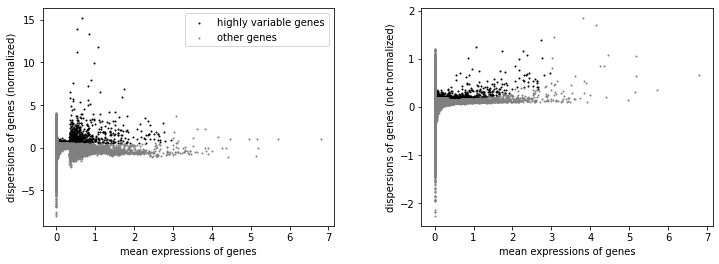

In [7]:
sc.pl.highly_variable_genes(adata, show=False)

In [8]:
adata.var["highly_variable"].sum()

1370

## PCA and neighbors for uncorrected data

In [9]:
sc.pp.pca(adata, svd_solver='arpack', n_comps=50, use_highly_variable=True)

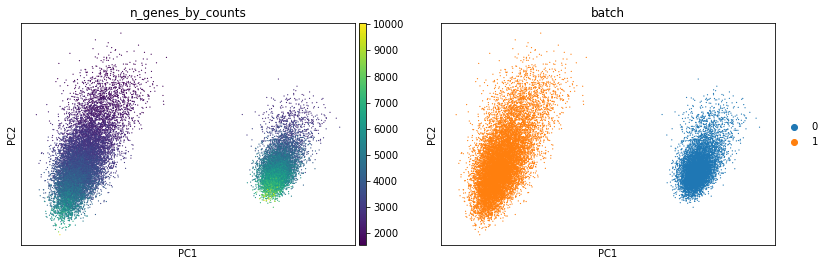

In [10]:
sc.pl.pca(adata, color=['n_genes_by_counts', batch_column])

In [11]:
sc.pp.neighbors(adata)

## Batch correction (optional)

In [12]:
batch_corrections = analyser.wrap_corrections(adata, 
                                              batch_key=batch_column,
                                              methods=batch_methods)

Running batch correction with 'bbknn'...
Running batch correction with 'combat'...
Found 22909 genes with zero variance.


/home/mbentse/.conda/envs/py3/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: invalid value encountered in true_divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()
/home/mbentse/.conda/envs/py3/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: divide by zero encountered in true_divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


[[ 0.00000000e+00  0.00000000e+00 -4.76211950e-03 ...  4.72332092e-01
  -1.28747456e-05  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -4.76211950e-03 ...  4.15596848e-01
  -1.28747456e-05  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -4.76211950e-03 ...  8.07881528e-01
  -1.28747456e-05  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  2.29818985e-03 ...  5.41186209e-02
   1.84673547e-05  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  2.29818985e-03 ...  5.41186209e-02
   1.84673547e-05  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  2.29818985e-03 ...  5.41186209e-02
   1.84673547e-05  0.00000000e+00]]
Running batch correction with 'mnn'...
Running batch correction with 'harmony'...
Running batch correction with 'scanorama'...
[[0.         0.16706277]
 [0.         0.        ]]
Processing datasets 0 <=> 1
Finished batch correction(s)!


In [13]:
batch_corrections.keys()

dict_keys(['bbknn', 'combat', 'mnn', 'harmony', 'scanorama', 'uncorrected'])

### Plot overview of batch corrections

In [14]:
#Run standard umap for all adatas
for adata in batch_corrections.values():
    sc.tl.umap(adata)

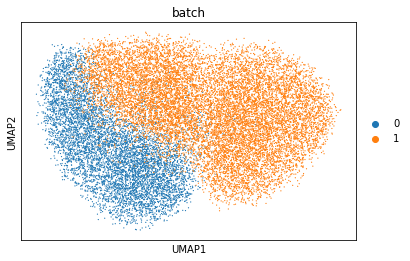

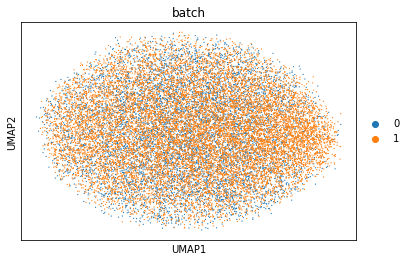

... storing 'sample' as categorical
... storing 'condition' as categorical
... storing 'batch' as categorical


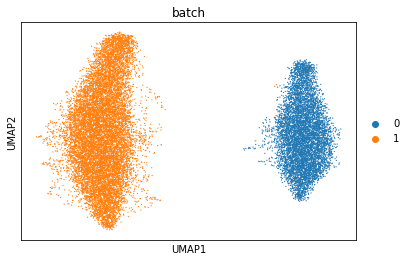

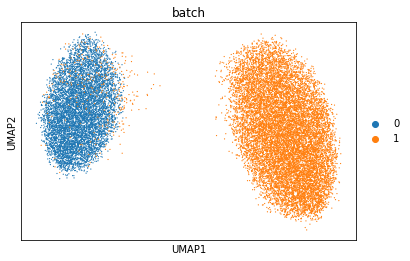

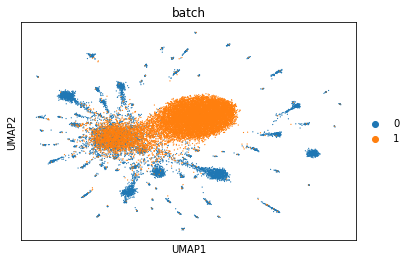

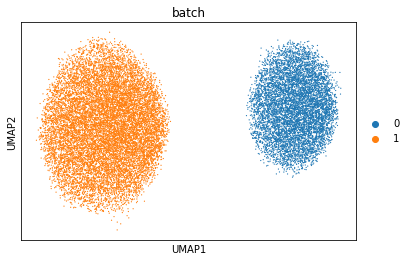

In [15]:
for adata in batch_corrections.values():
    sc.pl.umap(adata, color="batch")

### Select the final object

In [16]:
selected = "combat"

In [17]:
adata = batch_corrections[selected]

In [18]:
#Which anndata did you choose?
choose_non_corrected="No"
choose_Combat_correction="No"
choose_MNN_correction="Yes"
######################

path=path_results + "/" + "pca_final_anndata.png"

######################
yes=0
no=0
un=0
list_conds=[choose_non_corrected, choose_Combat_correction, choose_MNN_correction]
timer=0
def checking1(A, B, C):
    if A == "Yes" or A == "No":
        pass
    else:
        print("WARNING: Choose Yes or No for variable " + C[B])

for a in list_conds:
    if a == "Yes":
        yes=yes+1
    elif a == "No":
        no=no+1
    else:
        un=un+1
if un > 0:
    print("WARNING: One variable is not assigned as Yes or No.")
elif no == 3:
    print("WARNING: You must set at least one variable as Yes.")
elif yes > 1:
    print("WARNING: More than one variable is assigned as Yes.")
else:
    if choose_non_corrected == "Yes":
        print("Choose non-corrected.")
        adata=no_corr_adata.copy()
    else:
        if choose_Combat_correction == "Yes":
            print("Choose Combat corrected.")
            adata=Combat_adata.copy()
            name="Combat"
        elif choose_MNN_correction == "Yes":
            print("Choose MNN corrected.")
            adata=MNN_adata2.copy()
            name="MNN"
    n_rows = 1
    n_cols = 1
    fig, (ax1) = plt.subplots(n_rows, n_cols, figsize = (n_cols*7, n_rows*7))
    ax1_dict=sc.pl.pca(adata, ax=ax1, color=[data_to_evaluate], palette = adata.uns[data_to_evaluate + '_colors'], title=[data_to_evaluate], show=False)
    plt.savefig(path)

#Saving the anndata
print("Saving the anndata.")
adata_output= path_results + "/anndata_3_" + test +".h5ad"
adata.write(filename=adata_output)

NameError: name 'path_results' is not defined

## Saving adata for next notebook

In [ ]:
adata

In [ ]:
utils.saving_anndata(adata, current_notebook=3)